# Connect with Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Dataset Processing

Sample Data
--




Class: Covid 19 (299, 299)


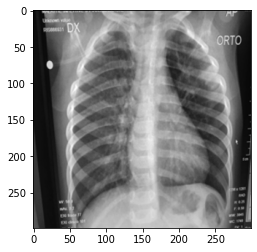

In [ ]:
data_img = cv2.imread("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Covid 19/COVID-4.png", cv2.IMREAD_GRAYSCALE)
print("Class: Covid 19 "+ str(data_img.shape))
plt.imshow(data_img, cmap="gray")

Class: Lung Opacity (299, 299)


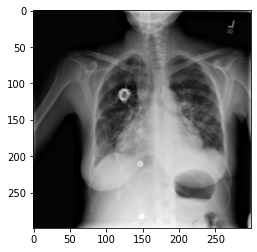

In [ ]:
data_img = cv2.imread("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Lung Opacity/Lung_Opacity-5.png", cv2.IMREAD_GRAYSCALE)
print("Class: Lung Opacity "+ str(data_img.shape))
plt.imshow(data_img, cmap="gray")

Class: Normal (299, 299)


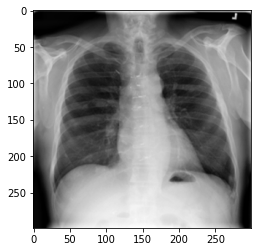

In [ ]:
data_img = cv2.imread("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Normal/Normal-15.png", cv2.IMREAD_GRAYSCALE)
print("Class: Normal "+ str(data_img.shape))
plt.imshow(data_img, cmap="gray")

Class: Viral Pneumonia (299, 299)


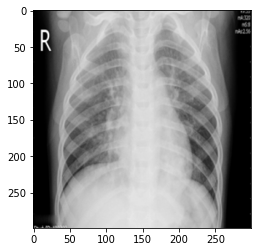

In [ ]:
data_img = cv2.imread("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Viral Pneumonia/Viral Pneumonia-4.png", cv2.IMREAD_GRAYSCALE)
print("Class: Viral Pneumonia "+ str(data_img.shape))
plt.imshow(data_img, cmap="gray")

# Define Path and Classes

In [ ]:
ImgPath = "/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/"
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

Collect Data
--

In [ ]:
img_size = 224

ImgData = []

def augment(image): # Data augmentation
  image = tf.cast(image, tf.float32)

  image = tf.image.random_crop(image, size=[img_size, img_size, 3])
  image = tf.image.random_brightness(image, max_delta=0.5)
  image = tf.image.random_flip_left_right(image)
  return image

def collect_Data():
  for cls in Classes:
    path = os.path.join(ImgPath, cls)
    cls_num = Classes.index(cls)

    count  = 0

    for img in os.listdir(path):
      try:
        data_img= cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        backtorgb = cv2.cvtColor(data_img, cv2.COLOR_GRAY2RGB)
        data_img = cv2.resize(backtorgb, (img_size, img_size))
        data_img = (data_img/255.0).astype(np.float32)
        ImgData.append([data_img, cls_num])

        count = count + 1
        if count == 1200:
          break

        img = augment(data_img) #Augment
        ImgData.append([img, cls_num])
          
      except Exception as e:
        pass

In [ ]:
collect_Data() # collect all images and their labels into a list

In [ ]:
print(len(ImgData)) # total number of image data

9596


In [ ]:
random.shuffle(ImgData) # shuffle all images to avoid overfitting

In [ ]:
X = []
Y = []
 
for img, label in ImgData:
  X.append(img) # takes all features or images
  Y.append(label) # takes all labels

In [ ]:
X = np.array(X).reshape(-1, img_size, img_size, 3)  # flatten the shape
Y = np.array(Y)

Pickle
--

In [ ]:
pickle_out = open("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/X.pickle", "wb")
pickle.dump(X, pickle_out, protocol=4) # protocol=4 is used for new version of pickle which can serialize more than 4GB data
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/Y.pickle", "wb")
pickle.dump(Y, pickle_out, protocol=4)
pickle_out.close()


# Input Data Sample

Import Required Libraries Again

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Imput Pickled Data
--

In [ ]:
pickle_in = open("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/X_2.pickle", "rb")
X = pickle.load(pickle_in)
 
pickle_in = open("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/Y_2.pickle", "rb")
Y = pickle.load(pickle_in)

In [ ]:
print('Data: ', len(X), len(Y))

Data:  9596 9596


Split Data into Train, Test and Validation Sets
--

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #20% data as test and validation data

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.50, random_state=1) #10% data as test and 10% as validation data

In [ ]:
print('Train:', len(X_train), len(Y_train), '\nTest: ', len(X_test), len(Y_test), '\nValidation: ', len(X_val), len(Y_val))

Train: 7676 7676 
Test:  960 960 
Validation:  960 960


Sample Data - Train Dataset
--

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


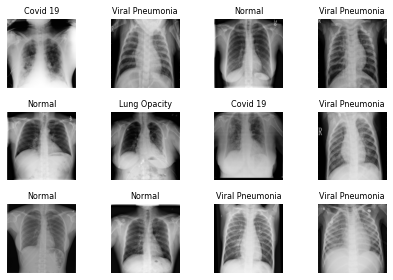

In [ ]:
def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title[:-2], fontsize=8)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

images = {str(Classes[Y_train[i]])+format(str(i).zfill(2)): X_train[i] for i in range(12)}

display_multiple_img(images, 3, 4)

# Model Uses for Classification

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(224, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 224)     6272      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 224)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     258176    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        1

In [ ]:
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"],
)

In [ ]:
filepath = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/model-{epoch:02d}-performance-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

checkpoint_loss = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]

epochs = 50
model_records = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/50
240/240 [==============================] - 2248s 9s/step - loss: 0.9639 - accuracy: 0.5810 - val_loss: 0.7955 - val_accuracy: 0.6458

Epoch 00001: val_accuracy improved from -inf to 0.64583, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/model-01-performance-0.65-0.80.hdf5

Epoch 00001: val_loss improved from inf to 0.79546, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/model-01-performance-0.65-0.80.hdf5
Epoch 2/50
240/240 [==============================] - 2232s 9s/step - loss: 0.7310 - accuracy: 0.7024 - val_loss: 0.7328 - val_accuracy: 0.7000

Epoch 00002: val_accuracy improved from 0.64583 to 0.70000, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/model-02-performance-0.70-0.73.hdf5

Epoch 00002: val_loss improved from 0.79546 to 0.73281, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle 

Learning Visualization
--

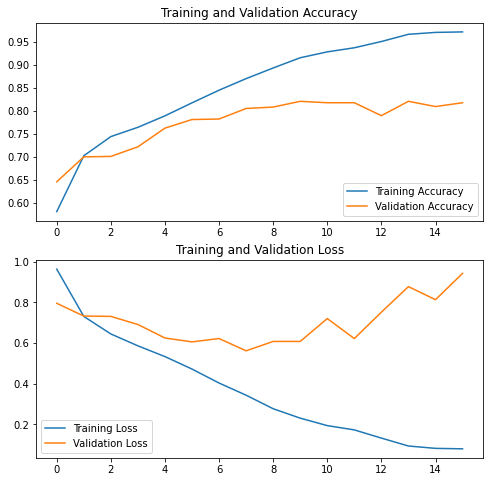

In [ ]:
train_acc = [0.5810, 0.7024,  0.7441, 0.7643, 0.7892, 0.8175, 0.8450, 0.8701, 0.8933, 0.9155, 0.9283, 0.9372, 0.9508, 0.9665, 0.9706, 0.9717]
val_acc = [0.6458, 0.7000, 0.7010, 0.7219, 0.7625, 0.7812, 0.7823, 0.8052, 0.8083, 0.8208, 0.8177, 0.8177, 0.7896, 0.8208, 0.8094,  0.8177]

train_loss = [0.9639, 0.7310, 0.6446, 0.5861, 0.5332, 0.4717, 0.4029, 0.3431, 0.2764, 0.2301, 0.1933, 0.1722, 0.1319, 0.0929, 0.0813, 0.0791]
val_loss = [0.7955, 0.7328, 0.7311, 0.6912, 0.6247, 0.6056, 0.6221, 0.5616, 0.6078, 0.6078, 0.7204, 0.6219, 0.7520, 0.8778, 0.8133, 0.9430]

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

## Performance on Test Data

Import Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Load Model
--

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/model-10-performance-0.82-0.61.hdf5')

Evaluate Model
--

In [ ]:
new_records = new_model.evaluate(X_test, Y_test)

30/30 [==============================] - 65s 2s/step - loss: 0.3386 - accuracy: 0.8917


Prediction on Unseen X-ray
--

In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

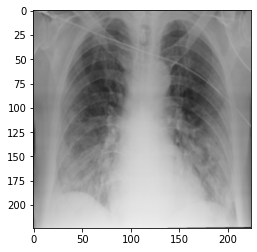

In [ ]:
img_size = 224
path = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Covid 19/COVID-1253.png'
data_img= cv2.imread(path, cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(data_img, cv2.COLOR_GRAY2RGB)
data_img = cv2.resize(backtorgb, (img_size, img_size))

plt.imshow(data_img)

data_img = np.array(data_img).reshape(-1, img_size, img_size, 3) 
data_img = (data_img/255.0).astype(np.float32)

In [ ]:
predictions = new_model.predict(data_img)

score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(Classes[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to Covid 19 with a 46.35 percent confidence.


# Performance Analysis

In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

In [ ]:
predictions = new_model.predict(X_test) # predict output for all test data

scores = tf.nn.softmax(predictions)
Y_pred = []
for score in scores:
  Y_pred.append(np.argmax(score))
Y_pred = np.array(Y_pred) # predicted labels

In [ ]:
Y_true = Y_test # true labels

Confusion Matrices
--

In [ ]:
# Defining function for confusion matrix plot
def plot_confusion_matrix(Y_true, Y_pred, Classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute the confusion matrix
    conf_mat = confusion_matrix(Y_true, Y_pred)
    if normalize:
        conf_mat = conf_mat.astype('float32') / conf_mat.sum(axis=1)[:, np.newaxis]
        print(title)
    else:
        print(title)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]),
           xticklabels=Classes, yticklabels=Classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
   
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

np.set_printoptions(precision=2)

Not normalized
--

Confusion Matrix


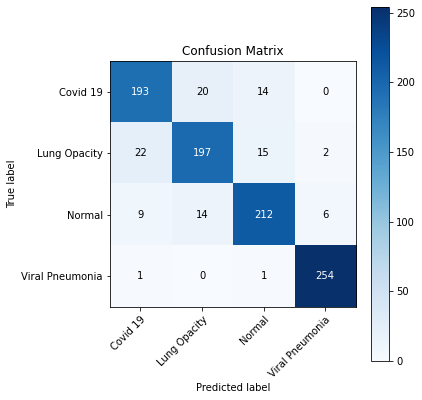

In [ ]:
from sklearn.metrics import confusion_matrix

#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, Classes = Classes, title='Confusion Matrix')

Normalized
--

Confusion Matrix - Normalized


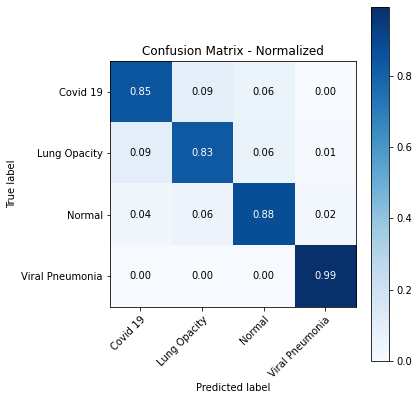

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, Classes = Classes, normalize = True, title = 'Confusion Matrix - Normalized')

In [ ]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
  print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
  print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'),4))
  print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
  print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))

get_metrics(Y_true, Y_pred)
  
def display_classification_report(true_labels, predicted_labels, Classes):
  report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=Classes)
  print("\nReport:\n"+report)

display_classification_report(Y_true, Y_pred, Classes)

Accuracy: 0.8917
Precision: 0.8909
Recall: 0.8917
F1 Score: 0.8912

Report:
                 precision    recall  f1-score   support

       Covid 19       0.86      0.85      0.85       227
   Lung Opacity       0.85      0.83      0.84       236
         Normal       0.88      0.88      0.88       241
Viral Pneumonia       0.97      0.99      0.98       256

       accuracy                           0.89       960
      macro avg       0.89      0.89      0.89       960
   weighted avg       0.89      0.89      0.89       960



ROC AUC score: 0.9266394736999706


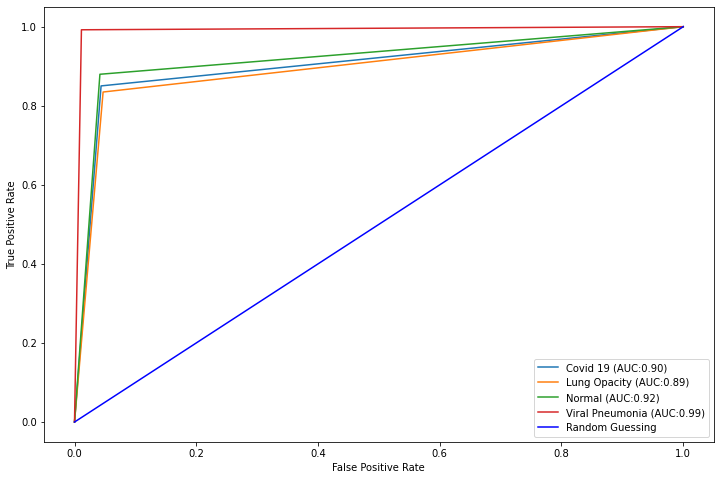

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= Classes

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  
  for (idx, c_label) in enumerate(target):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
  
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(Y_test, Y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

# Feature Outputs of Each Layer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/model-10-performance-0.82-0.61.hdf5')

In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

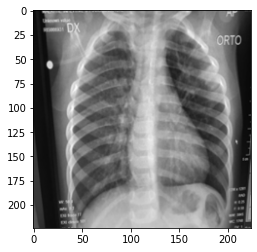

In [ ]:
img_size = 224
path = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Covid 19/COVID-4.png'
data_img= cv2.imread(path, cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(data_img, cv2.COLOR_GRAY2RGB)
data_img = cv2.resize(backtorgb, (img_size, img_size))

plt.imshow(data_img)

data_img = np.array(data_img).reshape(-1, img_size, img_size, 3) 
data_img = (data_img/255.0).astype(np.float32)

Output Dictionary
--

In [ ]:
layer_outputs = [layer.output for layer in new_model.layers]

feature_map_model = tf.keras.models.Model(new_model.input, layer_outputs)
feature_maps = feature_map_model.predict(data_img)

Feature Output
--

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


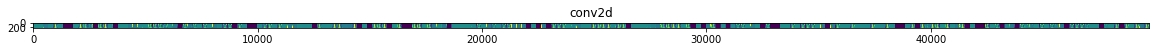

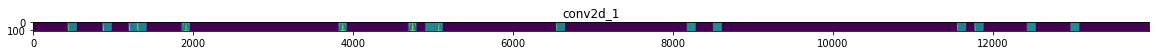

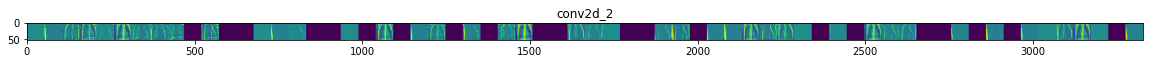

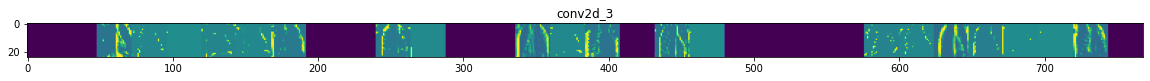

In [ ]:
layer_names = [layer.name for layer in new_model.layers]

for layer_name, feature_map in zip(layer_names, feature_maps):
  #print(feature_map.shape)
  if 'conv' in layer_name:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

Random Forest as Classfier
--

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/model-10-performance-0.82-0.61.hdf5')

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 224)     6272      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 224)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     258176    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        1

In [ ]:
new_rf_model= tf.keras.models.Model(inputs=new_model.input, outputs=new_model.layers[-4].output)

In [ ]:
new_rf_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 224)     6272      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 224)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     258176    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0     

In [ ]:
features_extractor = new_rf_model.predict(X_train)

In [ ]:
features = features_extractor.reshape(features_extractor.shape[0], -1)

In [ ]:
X_rf = features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [ ]:
RF_model.fit(X_rf, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
test_features_extractor = new_rf_model.predict(X_test)

In [ ]:
X_test_rf = test_features_extractor.reshape(test_features_extractor.shape[0], -1)

In [ ]:
RF_pred = RF_model.predict(X_test_rf)

In [ ]:
from sklearn import metrics
Acc = metrics.accuracy_score(Y_test, RF_pred)
print(Acc)

0.7822916666666667


In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

# Defining function for confusion matrix plot
def plot_confusion_matrix(Y_test, RF_pred, Classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute the confusion matrix
    conf_mat = confusion_matrix(Y_test, RF_pred)
    if normalize:
        conf_mat = conf_mat.astype('float32') / conf_mat.sum(axis=1)[:, np.newaxis]
        print(title)
    else:
        print(title)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]),
           xticklabels=Classes, yticklabels=Classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
   
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

np.set_printoptions(precision=2)

Confusion Matrix


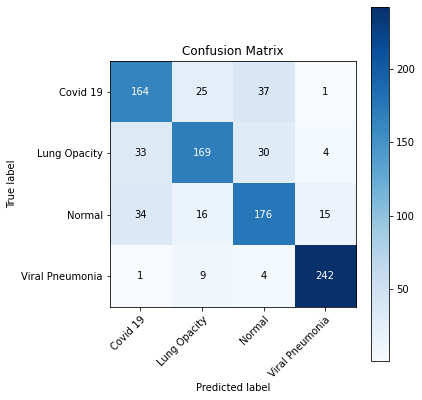

In [ ]:
from sklearn.metrics import confusion_matrix

#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_test, RF_pred)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred, Classes = Classes, title='Confusion Matrix')

Confusion Matrix - Normalized


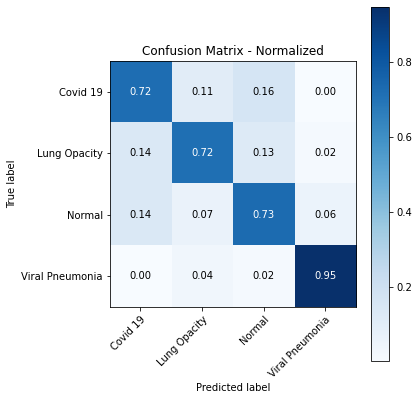

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred, Classes = Classes, normalize = True, title = 'Confusion Matrix - Normalized')

In [ ]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
  print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
  print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'),4))
  print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
  print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))

get_metrics(Y_test, RF_pred)
  
def display_classification_report(true_labels, predicted_labels, Classes):
  report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=Classes)
  print("\nReport:\n"+report)

display_classification_report(Y_test, RF_pred, Classes)

Accuracy: 0.7823
Precision: 0.782
Recall: 0.7823
F1 Score: 0.7818

Report:
                 precision    recall  f1-score   support

       Covid 19       0.71      0.72      0.71       227
   Lung Opacity       0.77      0.72      0.74       236
         Normal       0.71      0.73      0.72       241
Viral Pneumonia       0.92      0.95      0.93       256

       accuracy                           0.78       960
      macro avg       0.78      0.78      0.78       960
   weighted avg       0.78      0.78      0.78       960



ROC AUC score: 0.8531480056475432


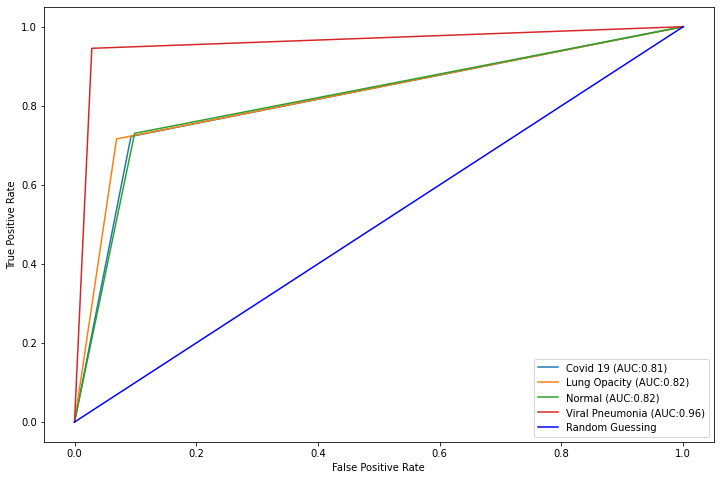

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= Classes

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  
  for (idx, c_label) in enumerate(target):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
  
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(Y_test, RF_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()